# Convolutional VAE

Reference : https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

import numpy as np

In [2]:
%config InlineBackend.figure_format='retina'
plt.rc('font', size=16)

In [3]:
dir_MNIST = '/home/hhg/Research/machine_learning/data'
batch_size = 256
kwargs = {'num_workers': 16, 'pin_memory': True}

# --- Set random seeds ---

torch.manual_seed(1)
torch.cuda.manual_seed(1)

# --- Define data loading step ---

#transforms_MNIST = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
transforms_MNIST = transforms.ToTensor()

#full_train_Dset = MNIST(dir_MNIST, train=True, download=True, transform=transforms_MNIST)
#train_Dset, valid_Dset = torch.utils.data.random_split(full_train_Dset, [50000, 10000])

train_Dset = MNIST(dir_MNIST, train=True, download=True, transform=transforms_MNIST)
test_Dset = MNIST(dir_MNIST, train=False, transform=transforms_MNIST)

print('--- sample size ---')
print(f'train sample: {len(train_Dset)}')
#print(f'valid sample: {len(valid_Dset)}')
print(f'test  sample: {len(test_Dset)}')

train_loader = torch.utils.data.DataLoader(train_Dset, batch_size=batch_size, shuffle=True, **kwargs)
#valid_loader = torch.utils.data.DataLoader(valid_Dset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_Dset, batch_size=batch_size, shuffle=True, **kwargs)

print('\n --- transformed image properties ---')
image, label = train_loader.dataset.__getitem__(10)
image_npy = np.array(image)
print(f'Min Pixel Value: {image_npy.min()} \nMax Pixel Value: {image_npy.max()}')


# --- Defining the device ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('\n --- run on device ---')
print(device)

--- sample size ---
train sample: 60000
test  sample: 10000

 --- transformed image properties ---
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927

 --- run on device ---
cuda:0


label : 2 | image.size() : torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

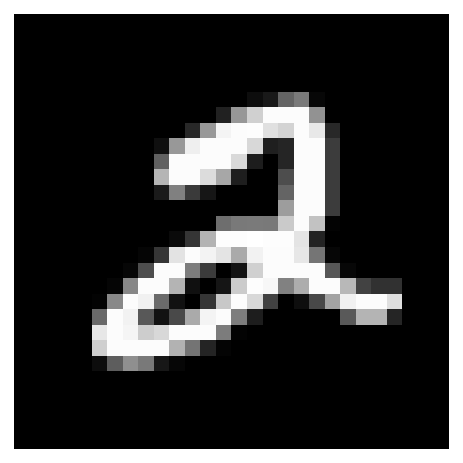

In [4]:
import torchvision.utils as vutils

### display single image ###
image, label = train_loader.dataset.__getitem__(5)
print(f'label : {label} | image.size() :', image.size())
plt.imshow(vutils.make_grid(image, normalize=True).numpy().transpose((1,2,0)))
plt.axis('off')

In [5]:
# --- Defining the model ---

d = 20
init_channels = 4
kernel_size = 4 # (4x4 convolutional kerenl)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.encoder = nn.Sequential(

            nn.Conv2d(1, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(init_channels*4, out_channels=64, kernel_size=kernel_size, stride=2, padding=0),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), # this layer doesn't really do anything is the 4th Conv2d out dimension is 64@1x1
            nn.Flatten(), # dim = (batch, 64)
            
            nn.Linear(64, 128),
            nn.Linear(128, d * 2)
        )
        
        
        self.decoder = nn.Sequential(
            
            nn.Linear(20, 64),
            nn.Unflatten(1, (64,1,1)),
            
            nn.ConvTranspose2d(64, out_channels=init_channels*8, kernel_size=kernel_size, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels*2, out_channels=1, kernel_size=kernel_size, stride=2, padding=3),

            nn.Sigmoid()            # Use Sigmoid function to let output pixels within [0, 1]
        )

    def reparameterise(self, mu, logvar):
        '''
            - working with log(σ^2) to assure that σ>=0.
              (logvar can range from [-inf, inf])
        '''
        if self.training:
            std = logvar.mul(0.5).exp_()             # σ = exp(1/2 log(σ^2))
            eps = std.data.new(std.size()).normal_() # ε ~ N(0, 1) (dim = std.size())
            return eps.mul(std).add_(mu)             # out = mu + ε x σ
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x).view(-1, 2, d) # reshape the encoder output to be (batchsize, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

# Total number of trainable parameters in the network
print('\n --- Number of trainable parameters in the network ---')
print('\tEncoder : ',sum(param.numel() for param in model.encoder.parameters() if param.requires_grad))
print('\tDecoder : ',sum(param.numel() for param in model.decoder.parameters() if param.requires_grad))
print('\tTotal   : ',sum(param.numel() for param in model.parameters() if param.requires_grad))


 --- Number of trainable parameters in the network ---
	Encoder :  32580
	Decoder :  44537
	Total   :  77117


In [6]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
    '''
        x_hat : generator image
        x     : target image
        
        Use BCE because each pixel in x or x_hat ranges from [0,1].
        
        KLD : KL divergence = 0.5 * sum(σ^2 - log(σ^2)-1 + μ^2)
            logvar.exp() = σ^2
    '''
    
    BCE = nn.functional.binary_cross_entropy( x_hat, x, reduction='sum' )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

In [8]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [9]:
def train_one_epoch(model, train_loader, test_loader, loss_function):
    
    output = {}
    
    # --- Training --- 
    model.train()    # sets the mode to train
    train_loss = 0.  # To store the sum of loss for 1 epoch
    for x, _ in train_loader:
        x = x.to(device)
        # ------------ forward ------------
        x_hat, mu, logvar = model(x)
        loss = loss_function(x_hat, x, mu, logvar)
        train_loss += loss.item()
        # ------------ backward -----------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    output['avg_train_loss'] = train_loss/len(train_loader.dataset)

    # --- Testing --- 
    means = []
    logvars = []
    labels = []
    with torch.no_grad():
        model.eval()  # sets the mode to test
        test_loss = 0.
        for x, y in test_loader:
            x = x.to(device)
            # ------------ forward ------------
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
            
        output['avg_test_loss'] = test_loss/len(test_loader.dataset)
    
    output['means'] = torch.cat(means)
    output['logvars'] = torch.cat(logvars)
    output['labels'] = torch.cat(labels)
    output['x'] = x
    output['x_hat'] = x_hat
    
    return output

In [10]:
epochs = 60
freq_printout = 3
codes = {'μ':[], 'logσ2':[], 'y':[]}

train_losses = []
test_losses = []

for epoch in range(1, epochs+1):
    output = train_one_epoch(model, train_loader, test_loader, loss_function)
    
    train_losses.append(output['avg_train_loss'])
    test_losses.append(output['avg_test_loss'])
    codes['μ'].append(output['means'])
    codes['logσ2'].append(output['logvars'])
    codes['y'].append(output['labels'])
    
    if epoch % freq_printout == 0:
        print(f' --- Epoch: {epoch} ------')
        print(f'\t\t avg. train loss : {train_losses[-1]:.3f}')
        print(f'\t\t avg. test  loss : {test_losses[-1]:.3f}')
        #display_images(output['x'], output['x_hat'], 1, f'Epoch {epoch}')

 --- Epoch: 3 ------
		 avg. train loss : 161.878
		 avg. test  loss : 145.365
 --- Epoch: 6 ------
		 avg. train loss : 130.567
		 avg. test  loss : 124.732
 --- Epoch: 9 ------
		 avg. train loss : 124.300
		 avg. test  loss : 120.411
 --- Epoch: 12 ------
		 avg. train loss : 120.238
		 avg. test  loss : 115.241
 --- Epoch: 15 ------
		 avg. train loss : 117.140
		 avg. test  loss : 114.200
 --- Epoch: 18 ------
		 avg. train loss : 115.716
		 avg. test  loss : 111.746
 --- Epoch: 21 ------
		 avg. train loss : 114.776
		 avg. test  loss : 110.881
 --- Epoch: 24 ------
		 avg. train loss : 113.863
		 avg. test  loss : 110.226
 --- Epoch: 27 ------
		 avg. train loss : 112.445
		 avg. test  loss : 108.437
 --- Epoch: 30 ------
		 avg. train loss : 111.282
		 avg. test  loss : 107.550
 --- Epoch: 33 ------
		 avg. train loss : 110.173
		 avg. test  loss : 106.152
 --- Epoch: 36 ------
		 avg. train loss : 109.103
		 avg. test  loss : 104.544
 --- Epoch: 39 ------
		 avg. train loss : 

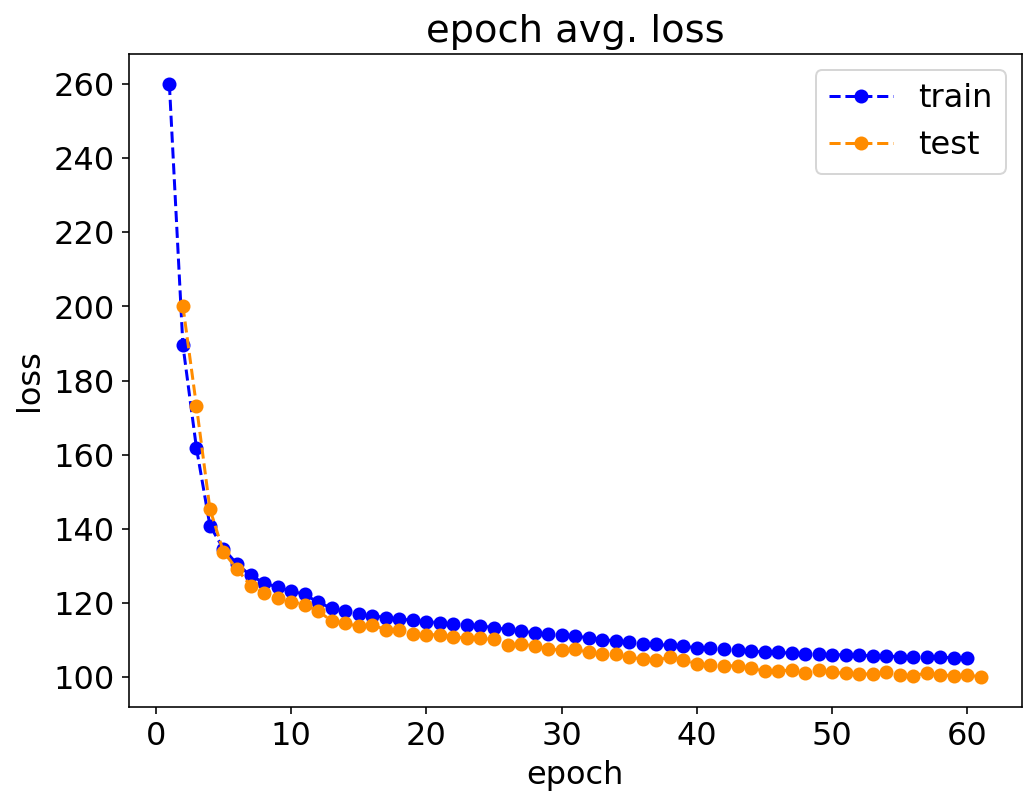

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.rc('font', size=16)

epoch_tick  = range(1, len(train_losses)+1)
epoch_tick2 = range(2, len(test_losses)+2)
#epoch_tick2 = range(1, len(test_losses)+1)

ax.plot(epoch_tick , train_losses, 'o--', label='train', color='b')
ax.plot(epoch_tick2, test_losses , 'o--', label='test' , color='darkorange')

ax.set_title('epoch avg. loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()

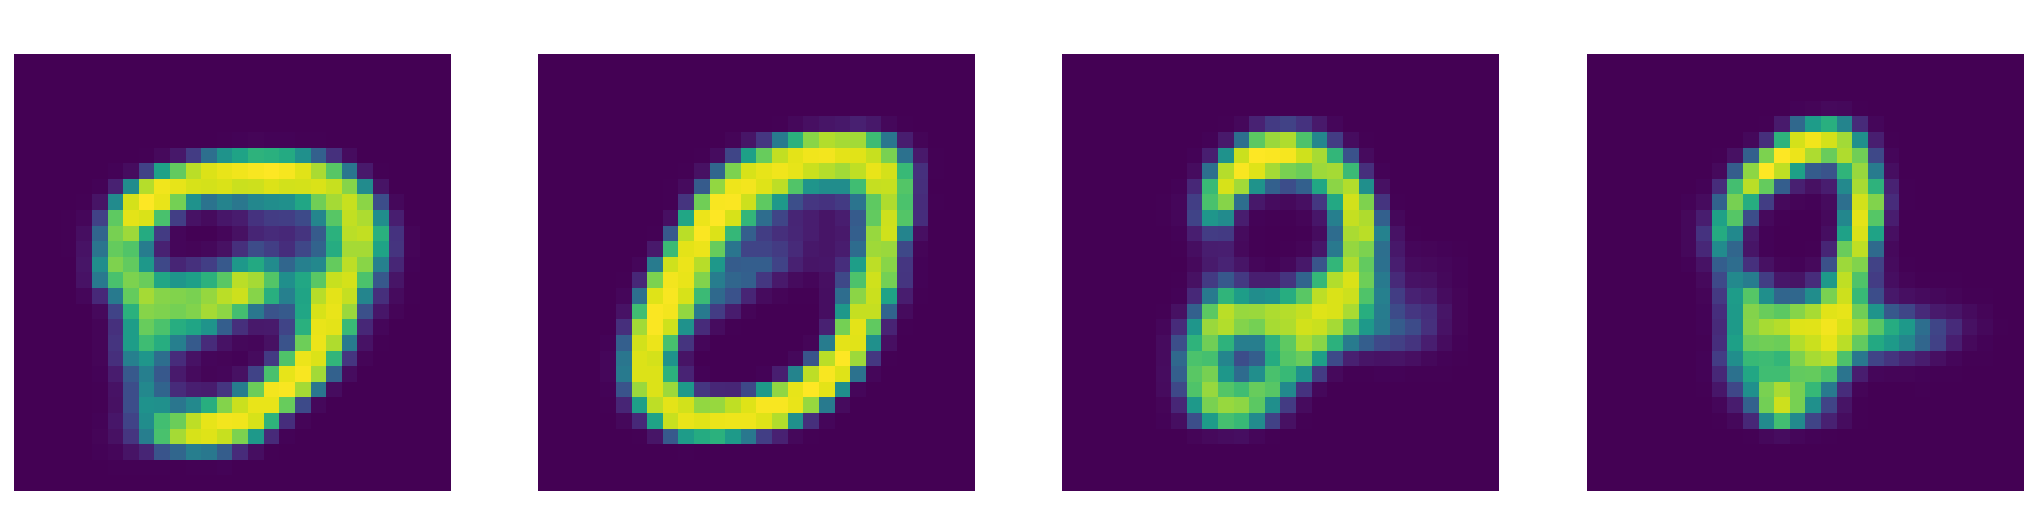

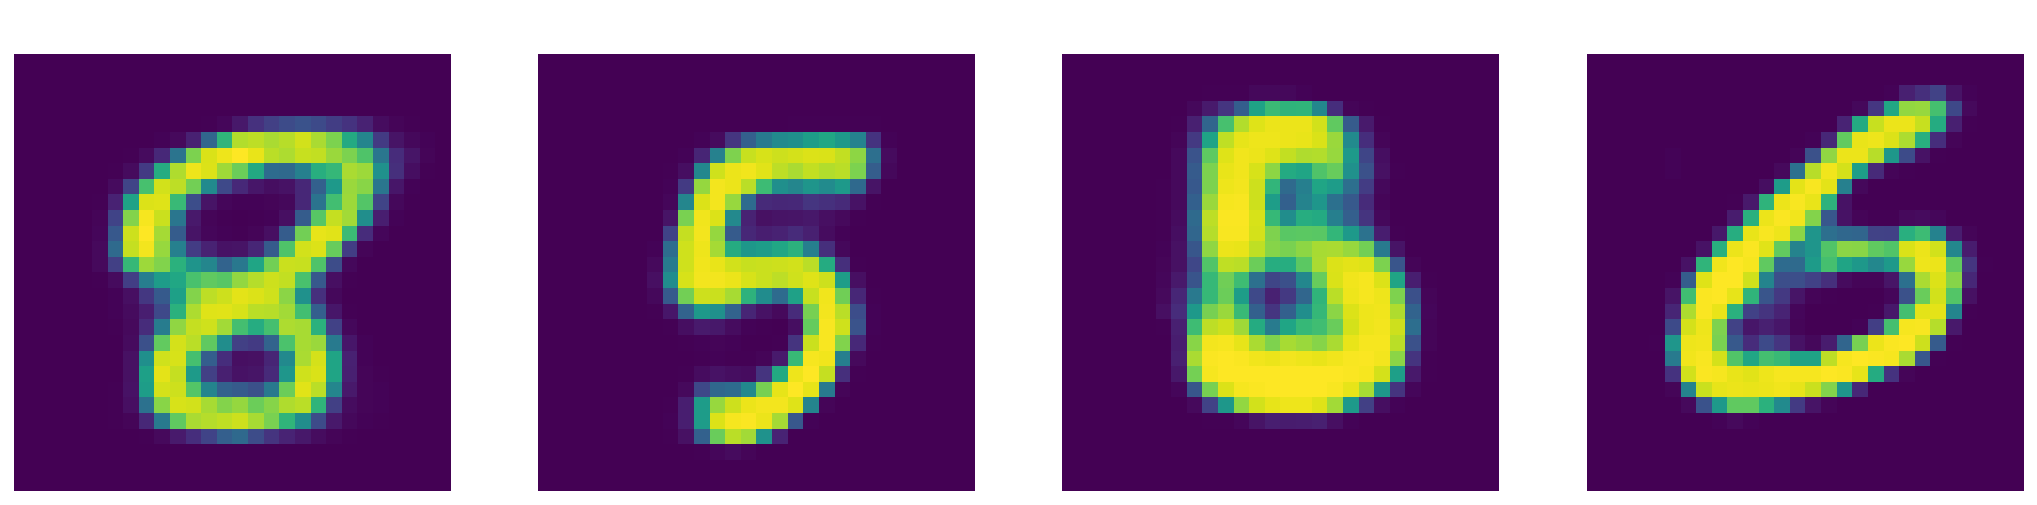

In [12]:
# Generating a few samples

N = 8
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

In [13]:
from sklearn.manifold import TSNE

In [14]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N].cpu())
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

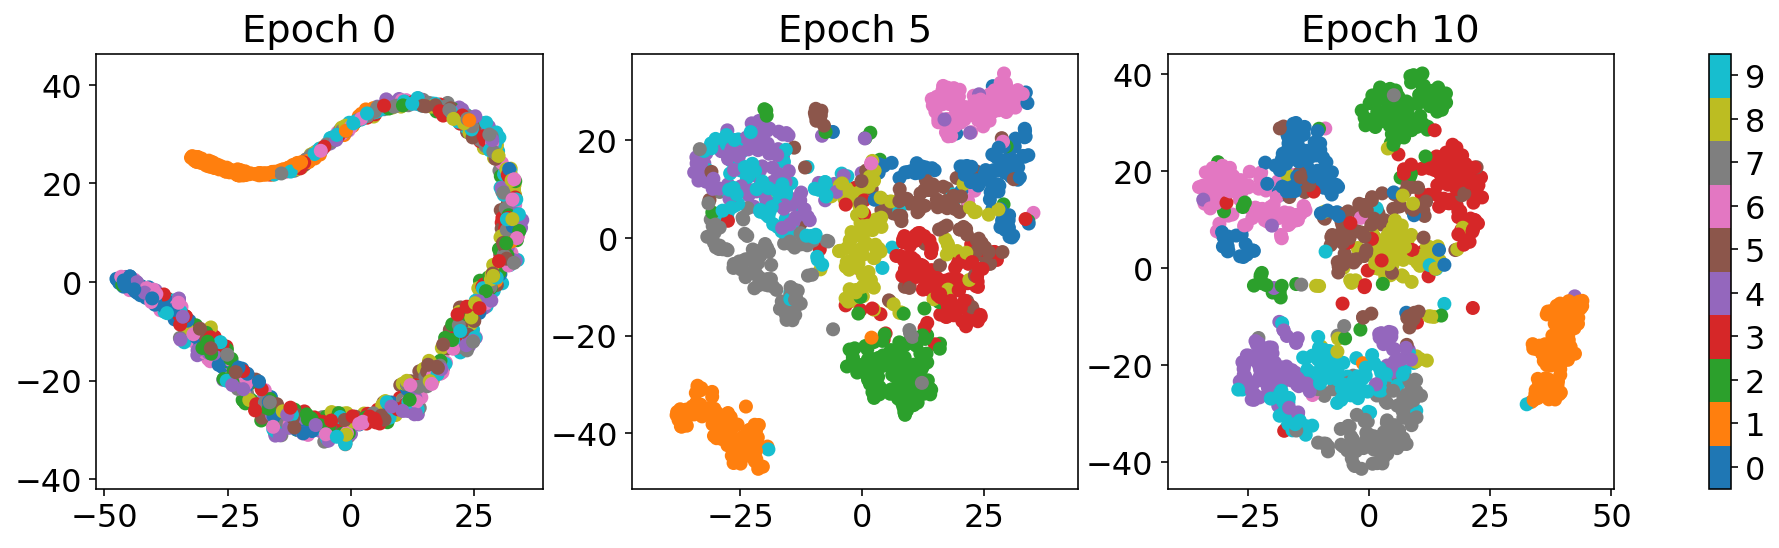

In [15]:
f, a = plt.subplots(ncols=3, figsize=(17, 4))
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

# ------ End ------